In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, time, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import shap
shap.initjs()

from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

#models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.svm import SVR

 
mpl.rcParams['lines.linewidth'] = 2

figsize=(12,9)

np.random.seed(238746)


import warnings
warnings.filterwarnings("ignore")

In [2]:
SplitTestDate = "2019-06-23"

In [3]:
models = {
    "xgb" : xgb.XGBRegressor(n_estimators=500, learning_rate=0.1),
    #"forest" : RandomForestRegressor(n_estimators=100),
    "extra": ExtraTreesRegressor(n_estimators=500)
}

features_for_model = {

    "xgb" : ['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"],
    "extra": ['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"],
    "final": ["group_A","group_B",'scaled_price','scaled_diff1','scaled_diff2',"scaled_sales1"]
}

finalreg = RandomForestRegressor(n_estimators=100)

In [4]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=123)
min_max_scaler = preprocessing.MinMaxScaler()

def scale(feature, scaler = min_max_scaler):
    size = len(feature)
    return scaler.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
def unscale(scaled, original, scaler = min_max_scaler):
    size2 = len(scaled)
    size1 = len(original)
    return scaler.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_results(ytrue, prediction, label):
    df_ytrue = pd.DataFrame(ytrue)
    df_ytrue['predicted'] =  prediction 
    plt.plot(df_ytrue[label],label='data')
    plt.plot(df_ytrue['predicted'],label='predicted')
    plt.xticks(rotation=45)
    mape = mean_absolute_percentage_error(df_ytrue[label],df_ytrue['predicted'])

    plt.title("Forecasting on Test Set MAPE=%.3f"%mape)
    plt.legend();
    plt.show()
    return mape
    
def plot_scaled_results(prediction, y_test, rescale):
    results = pd.DataFrame(columns = ["sku","target","prediction"])

    for sku in y_test["sku"].unique():

        pred_sku = prediction[np.where(y_test["sku"] == sku)]
        originals = rescale.loc[rescale["sku"] == sku]["target"]
        pred = unscale(pred_sku,originals)

        results = pd.concat([results, pd.DataFrame({
            "date" : y_test[y_test["sku"] == sku]["date"],
            "sku" : y_test[y_test["sku"] == sku]["sku"],
            "scaled_target" : y_test[y_test["sku"] == sku]["scaled_target"],
            "target" : y_test[y_test["sku"] == sku]["target"],
            "scaled_prediction" : pred_sku,
            "prediction" : pred
        })])
    results = results.dropna().set_index("date")

    return plot_results(results["target"], results["prediction"], "target"), results

In [6]:
def predict_training(model,X,y,label = "scaled_target",span = 24):
    
    #k = number of folds
    k = int(len(X_train)/span)
    
    prediction = pd.DataFrame(columns = ["date","sku","pred"])    
    
    for fold in range(0,k):
        if fold != k - 1:
            validation = X_train.iloc[fold*span:(fold+1)*span]
        else:
            validation = X_train.iloc[fold*span:]
        print("fold %d of %d" %(fold,k))
        
        training = X_train[~X_train.index.isin(validation.index)]
        y_tr  = y_train[~y_train.index.isin(validation.index)]
        y_val  = y_train[y_train.index.isin(validation.index)]

        model.fit(training, y_tr[label])
        partial_pred = pd.DataFrame()
        partial_pred["date"] = y_val["date"]
        partial_pred["sku"] = y_val["sku"]
        partial_pred["pred"] = model.predict(validation)
        partial_pred.set_index(validation.index)
        prediction = prediction.append(partial_pred)
        
    return prediction

In [7]:
def StackingPred(models,final_model, X_train, y_train, X_test,features_for_model, span = 3, label = "scaled_target"):
    onehot_encoder = OneHotEncoder(sparse=False)

    #TRAIN SET PREDICTION WITH MODELS
    
    results_dict = {}
    for name, model in models.items():
        print("predict training with " + name)
        X = X_train
        onehot_encoded = pd.get_dummies(y_train["sku"]) > 0
        onehot = pd.DataFrame(onehot_encoded, index = X_train.index)
        X = pd.concat([onehot,X],axis = 1)
        results_dict.update({name : predict_training(model, X, y_train,"scaled_target",span)})
    
    train_result = pd.DataFrame(index = y_train.index)
    for name,r in results_dict.items():
        train_result["date"] = r["date"]
        train_result["sku"] = r["sku"]
        train_result[name] = r["pred"]
    
    #TEST SET PREDICTION WITH MODELS
    prediction_df = pd.DataFrame()
    for name, model in models.items():
        print("predict test with " + name)
        X = X_train
        onehot_encoded = pd.get_dummies(y_train["sku"]) > 0
        onehot = pd.DataFrame(onehot_encoded, index = X_train.index)
        X = pd.concat([onehot,X],axis = 1)
        model = model.fit(X, y_train["scaled_target"]) 
        X = X_test
        onehot_encoded = pd.get_dummies(y_test["sku"]) > 0
        onehot = pd.DataFrame(onehot_encoded, index = X_test.index)
        X = pd.concat([onehot,X],axis = 1)
        prediction_df[name] = model.predict(X)
    prediction_df.index = X_test.index
    
    #DUMMY VARIABLES FOR FINAL TRAIN AND TEST
    onehot_encoded = pd.get_dummies(train_result["sku"]) > 0
    onehot = pd.DataFrame(onehot_encoded, index = train_result.index)
    final_train = pd.concat([onehot,X_train[features_for_model["final"]] ,train_result[models.keys()]],axis = 1)

    onehot_encoded = pd.get_dummies(y_test["sku"]) > 0
    onehot = pd.DataFrame(onehot_encoded, index = y_test.index)
    final_test = pd.concat([onehot,X_test[features_for_model["final"]],prediction_df[models.keys()]],axis = 1)

    
    #TRAIN ON TRAIN PREDICTIONS AND PREDICTION ON TEST PREDICTIONS
    print("prediction with final")
    final_model.fit(final_train, y_train["scaled_target"])
    final_pred = final_model.predict(final_test)

    return final_pred, train_result, prediction_df

In [8]:
df = pd.read_csv('data/processed_train.csv',index_col = 0)
df_test = pd.read_csv('data/processed_test.csv',index_col = 0)

df = df.loc[df.scope == 1]
df_test = df_test.loc[df.scope == 1]
df.date = df.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df_test.date = df_test.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

df = df.sort_values(by=["date",'sku'])
df_test = df_test.sort_values(by=["date",'sku'])

In [9]:
rescale_df = pd.concat([df,df_test])[["target","sku"]].dropna()

In [10]:
df = pd.concat([df,df_test])

In [11]:
simple_df = df[['scaled_quarter','scaled_month','scaled_year','scaled_price_diff1',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2",
                "date","sku","scaled_target","target"]]
simple_df = simple_df.dropna().set_index("date")
simple_train = simple_df[:SplitTestDate].reset_index()
simple_test = simple_df[SplitTestDate:].reset_index()

In [12]:
X_train = simple_train[['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"]]

In [13]:
y_train = simple_train[["date","sku","scaled_target","target"]]

In [14]:
X_test = simple_test[['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"]]

In [15]:
y_test = simple_test[["date","sku","scaled_target","target"]]

In [16]:
y_test

,date,sku,scaled_target,target
0,2019-06-29,144,0.063781,16228.0
1,2019-06-29,546,0.071891,61407.0
2,2019-06-29,549,0.108526,33777.0
3,2019-06-29,554,0.155733,122673.0
4,2019-06-29,686,0.087701,21177.0
...,...,...,...,...
283,2019-12-07,1035,0.098481,38087.0
284,2019-12-07,1051,0.312093,24597.0
285,2019-12-07,1058,0.122768,27794.0
286,2019-12-07,1065,0.113069,79456.0


In [17]:
res, train, test = StackingPred(models,finalreg, X_train, y_train, X_test,features_for_model, span = 12, label = "scaled_target")


predict training with xgb
fold 0 of 130
fold 1 of 130
fold 2 of 130
fold 3 of 130
fold 4 of 130
fold 5 of 130
fold 6 of 130
fold 7 of 130
fold 8 of 130
fold 9 of 130
fold 10 of 130
fold 11 of 130
fold 12 of 130
fold 13 of 130
fold 14 of 130
fold 15 of 130
fold 16 of 130
fold 17 of 130
fold 18 of 130
fold 19 of 130
fold 20 of 130
fold 21 of 130
fold 22 of 130
fold 23 of 130
fold 24 of 130
fold 25 of 130
fold 26 of 130
fold 27 of 130
fold 28 of 130
fold 29 of 130
fold 30 of 130
fold 31 of 130
fold 32 of 130
fold 33 of 130
fold 34 of 130
fold 35 of 130
fold 36 of 130
fold 37 of 130
fold 38 of 130
fold 39 of 130
fold 40 of 130
fold 41 of 130
fold 42 of 130
fold 43 of 130
fold 44 of 130
fold 45 of 130
fold 46 of 130
fold 47 of 130
fold 48 of 130
fold 49 of 130
fold 50 of 130
fold 51 of 130
fold 52 of 130
fold 53 of 130
fold 54 of 130
fold 55 of 130
fold 56 of 130
fold 57 of 130
fold 58 of 130
fold 59 of 130
fold 60 of 130
fold 61 of 130
fold 62 of 130
fold 63 of 130
fold 64 of 130
fold 65 o

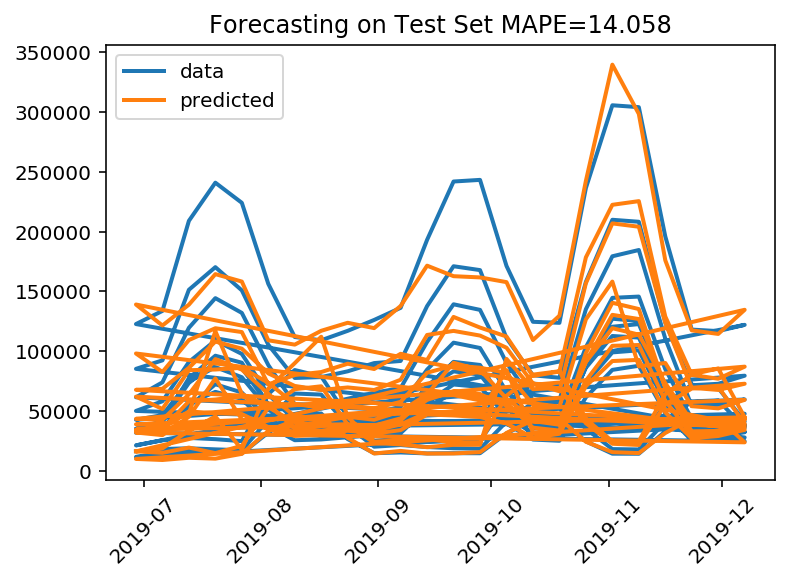

In [18]:
mape,results = plot_scaled_results(res, y_test, rescale_df)

In [19]:
test

,xgb,extra
0,0.074389,0.063807
1,0.099353,0.117298
2,0.113971,0.131231
3,0.182521,0.190005
4,0.059097,0.069748
...,...,...
283,0.146977,0.129735
284,0.310435,0.312314
285,0.184851,0.171719
286,0.161152,0.148048


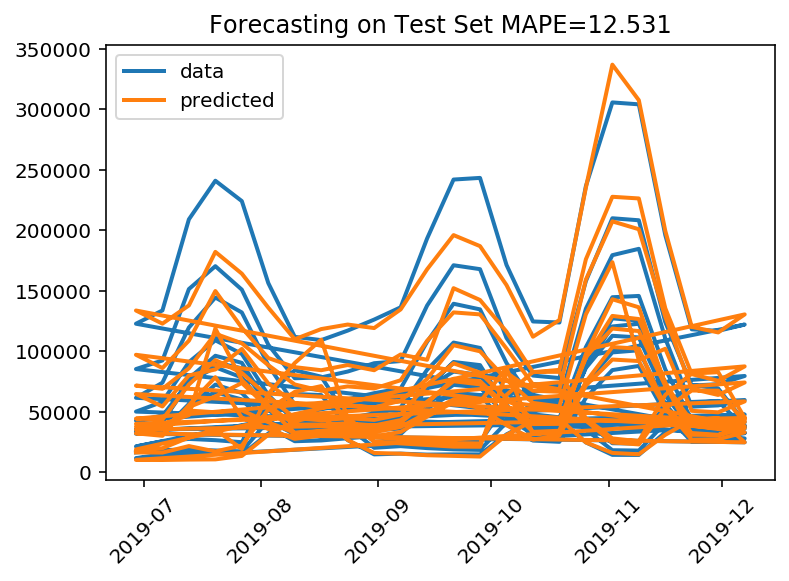

In [20]:
xgb_pred = np.array(test["extra"])
mape,results = plot_scaled_results(xgb_pred, y_test, rescale_df) 